In [1]:
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling1D, Add, Input,  MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt

In [2]:
# Load scaled dataset
df = pd.read_csv("scaled_data.csv")

# Load scaler (for inverse transformation)
target_scaler = joblib.load("target_scaler.pkl")

# Define target variable (e.g., predicting "Close" price)
target_col = "Close"
features = df.drop(columns=["Date", target_col])  # Exclude 'Date' and target from features
target = df[target_col]

# Convert to NumPy arrays
X = features.values
y = target.values


In [3]:
# Create sequences (time-series window)
def create_sequences(X, y, time_steps=30):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i : i + time_steps])  # Last 'time_steps' inputs
        y_seq.append(y[i + time_steps])  # Predict the next value
    return np.array(X_seq), np.array(y_seq)


In [4]:
# Define time step window
TIME_STEPS = 30

# Prepare sequences
X_seq, y_seq = create_sequences(X, y, time_steps=TIME_STEPS)

# Split into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Reshape for CNN (Conv1D requires 3D input: (samples, time steps, features))
print("Training shape:", X_train.shape, "Test shape:", X_test.shape)

Training shape: (1063, 30, 12) Test shape: (266, 30, 12)


In [5]:
# Define CNN model
cnn = Sequential([
    # Première couche de convolution
    Conv1D(filters=128, kernel_size=3, activation="relu", input_shape=(TIME_STEPS, X.shape[1])),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    # Deuxième couche de convolution
    Conv1D(filters=64, kernel_size=3, activation="relu"),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    # Troisième couche de convolution
    Conv1D(filters=32, kernel_size=3, activation="relu"),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    # Flatten la sortie pour la couche dense
    Flatten(),
    
    # Couche dense pour extraction des features
    Dense(64, activation="relu", name="feature_layer"),
    Dropout(0.4),
    
    # Couche dense supplémentaire
    Dense(32, activation="relu"),
    Dropout(0.4),
    
    # Couche de sortie
    Dense(1)
])

# Compile CNN model
cnn.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Train CNN model
cnn.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50


C:\Users\Aleix\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 342550656.0000 - mae: 13363.0010 - val_loss: 401268512.0000 - val_mae: 14199.9072
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 346077856.0000 - mae: 13222.5293 - val_loss: 219415520.0000 - val_mae: 8926.4287
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 133530064.0000 - mae: 7412.4092 - val_loss: 59135528.0000 - val_mae: 4178.8125
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 89200264.0000 - mae: 5794.8057 - val_loss: 28901698.0000 - val_mae: 3246.1355
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 56674064.0000 - mae: 4669.8892 - val_loss: 30003580.0000 - val_mae: 2919.1384
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 39088072.0000 - mae: 3685.0796 - val_loss: 25893980.0000 - val_mae: 2785.8972
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 53715516.0000 - mae: 4065.1050 - val_loss: 33126104.0000 - val_mae: 3485.6663
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

In [6]:
# Ensure the model is built and called with a sample batch
sample_batch = X_train[:1]  # Take the first sample batch
_ = cnn(sample_batch)  # Call the model with the sample batch

# Extract feature model (everything before the last layer)
feature_extractor = Model(inputs=cnn.inputs, outputs=cnn.get_layer("feature_layer").output)

# Extract features for training XGBoost
X_train_cnn_features = feature_extractor.predict(X_train)
X_test_cnn_features = feature_extractor.predict(X_test)

print("Extracted CNN Features Shape:", X_train_cnn_features.shape)  # Should be (num_samples, 32)

24/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

C:\Users\Aleix\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 30, 12))
  warnings.warn(msg)
C:\Users\Aleix\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 30, 12))
  warnings.warn(msg)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Extracted CNN Features Shape: (1063, 64)


Mean Squared Error (MSE): 2491449.6324
Root Mean Squared Error (RMSE): 1578.4327
Mean Absolute Error (MAE): 867.2472
R-squared (R²) Score: 0.9875


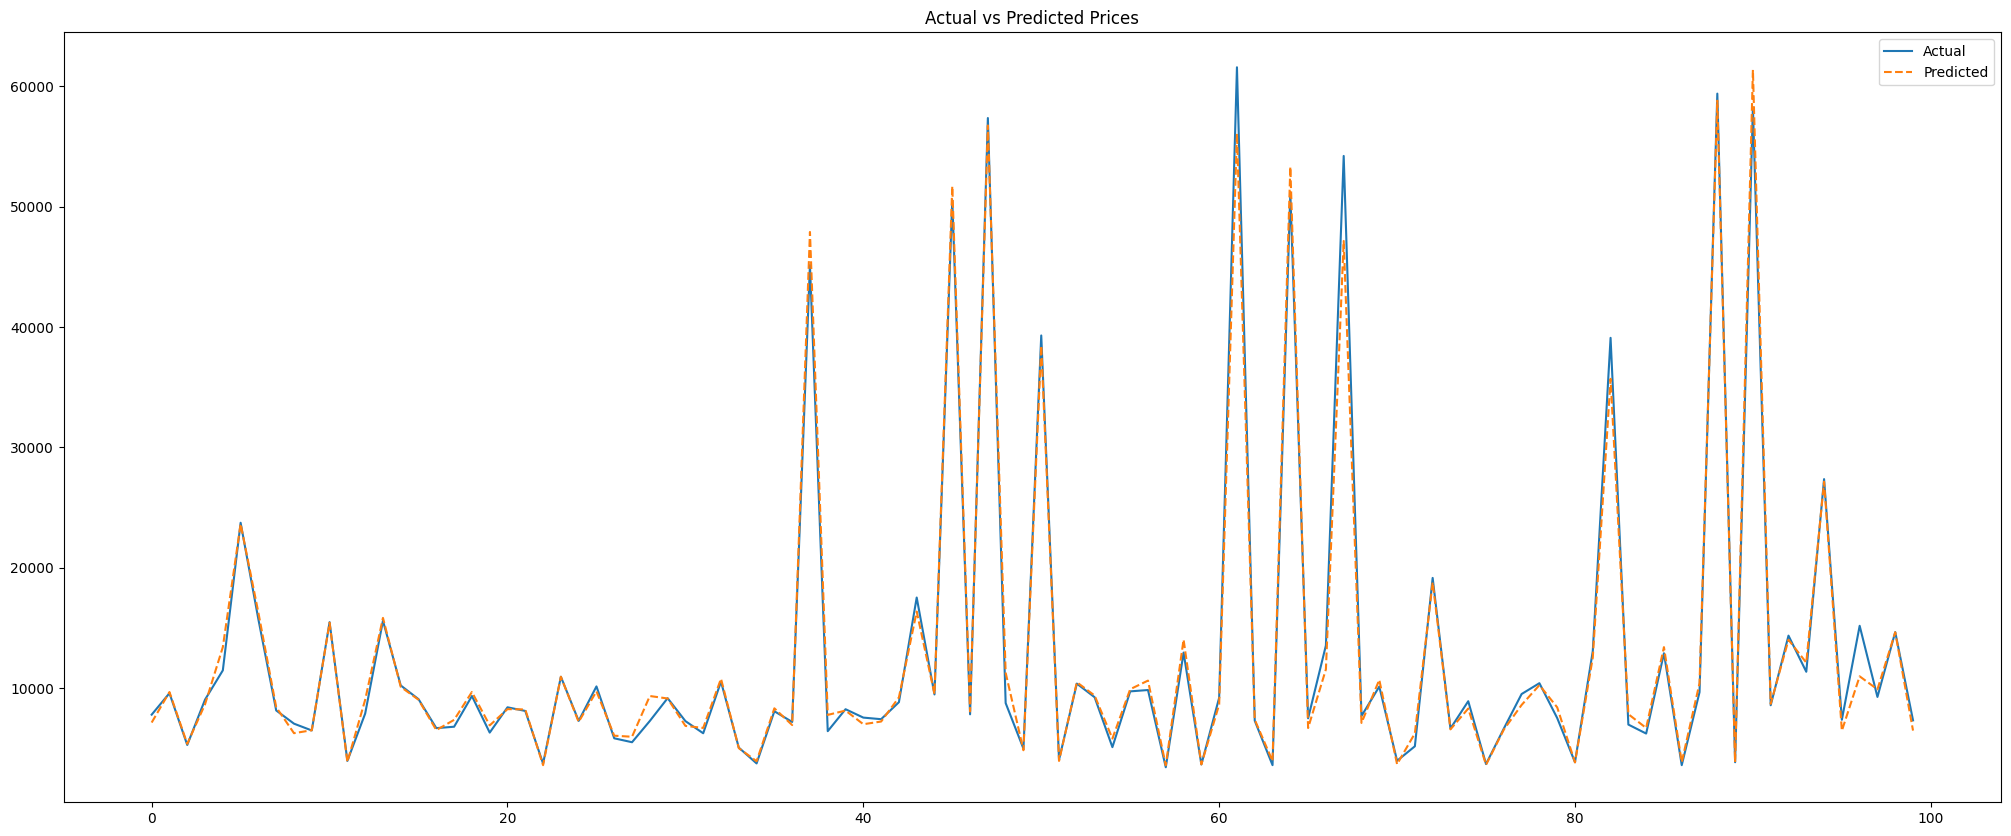

In [7]:
xgb_model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=10, random_state=42)
xgb_model.fit(X_train_cnn_features, y_train)  # No need to scale y_train

# Make predictions
y_pred_xgb = xgb_model.predict(X_test_cnn_features)

# Compute evaluation metrics
mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_xgb)
r2 = r2_score(y_test, y_pred_xgb)

# Print results
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²) Score: {r2:.4f}")

# Plot actual vs predicted values
plt.figure(figsize=(25, 10))
plt.plot(y_test[0:100], label="Actual")
plt.plot(y_pred_xgb[0:100], label="Predicted", linestyle="dashed")
plt.title("Actual vs Predicted Prices")
plt.legend()


plt.show()


In [8]:
import joblib

class CombinedModel:
    def __init__(self, cnn_model, xgb_model):
        self.cnn_model = cnn_model
        self.xgb_model = xgb_model

    def predict(self, X):
        # Extract features using CNN
        cnn_features = self.cnn_model.predict(X)
        # Predict using XGBoost
        return self.xgb_model.predict(cnn_features)

# Create the combined model
combined_model = CombinedModel(feature_extractor, xgb_model)

# Save the combined model
joblib.dump(combined_model, "combined_model.pkl")

['combined_model.pkl']

In [9]:
print(y_test)

[ 7795.60083451  9578.62988281  5279.34821147  9043.94042969
 11474.90039062 23735.94972763 15701.33973237  8144.19451744
  7047.16        6482.35       15479.56703842  3954.1182433
  7881.84672105 15599.20019531 10221.09960938  9081.76202252
  6675.35009766  6793.62459642  9344.36529292  6305.8
  8406.5160678   8103.91137325  3728.56836493 10944.5858045
  7278.1197833  10141.9963705   5831.16747167  5505.28367176
  7271.20790408  9164.2313647   7260.06        6249.18017578
 10538.4603213   5059.81718799  3745.95076478  8078.20332194
  7189.42482356 45137.77046805  6423.76        8247.1796875
  7550.90102725  7419.29003906  8830.75       17527.
  9475.27733834 50538.24341445  7824.23153913 57356.40187692
  8756.43114193  4973.02181522 39294.19738214  4048.72590374
 10374.3393471   9243.61385509  5096.58656276  9729.32376435
  9842.66636785  3424.58807495 12952.20019531  3657.83943502
  9199.58483269 61572.78960116  7292.99507783  3601.0135915
 51093.65070999  7494.16992188 13546.522269

In [10]:
print(y_pred_xgb)

[ 7139.9146  9675.199   5371.454   8661.086  13406.022  23640.744
 16257.23    8413.945   6256.362   6502.707  15435.666   3867.5522
  9028.338  15833.424  10101.879   9034.856   6511.3555  7364.5874
  9678.359   6903.5264  8255.237   8228.014   3599.6294 10945.921
  7191.7197  9732.223   6048.011   5960.078   9344.052   9139.244
  6862.467   6692.603  10780.378   5013.7705  3928.528   8321.872
  6933.37   47892.348   7775.126   8135.5645  7002.1274  7223.186
  9227.9    16359.794   9505.303  51690.66    8067.4307 56740.875
 11274.703   4840.9097 38437.203   3953.5718 10489.144   9384.682
  5812.391   9910.339  10624.448   3588.349  14030.645   3663.9119
  8641.5625 56074.12    7381.024   3942.6177 53303.797   6687.4717
 11563.481  47145.47    7106.7344 10688.325   3676.0774  6241.149
 18792.36    6574.2983  8305.305   3632.114   6553.293   8603.066
 10249.004   8404.12    3828.198  12539.08   35692.527   7834.1895
  6690.623  13406.022   3846.8555 10409.306  58797.62    3852.6514
 613